In [1]:
import torchtrainer
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# instanciando o modelo
model_layers = (1, 1, 1)
model_channels = (64, 64, 64)
model = torchtrainer.models.resunet.ResUNetV2((8,), (1,), (64,))
# carregando o state_dict
baseline_state_dict = torch.load('./unetv2_da/checkpoint_best.pth')['model']
model.load_state_dict(baseline_state_dict)
model.eval();

In [3]:
valid_imgs = ['Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@69-Image 1-20X.tiff', 
              'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@40-Image 2-20X.tiff', 
              'Experiment #1 (adults set #1)_20x_batch1 - Superfical layers@68-Image 2-20X.tiff']

In [4]:
def dataset_stats(img_dir):
    '''Calcula as estatísticas da base para fazer o zscore'''
    dataset_pixels = []
    for fname in os.listdir(img_dir):
        img = np.asarray(Image.open(f'{img_dir}/{fname}'), dtype=np.float32)
        dataset_pixels += list(img.reshape(-1))
    dataset_pixels = np.array(dataset_pixels)

    return dataset_pixels.mean(), dataset_pixels.std()

def zscore(img, ORIG_MEAN, ORIG_STD):
    return torch.tensor(((img-ORIG_MEAN))/ORIG_STD, dtype=torch.float32)

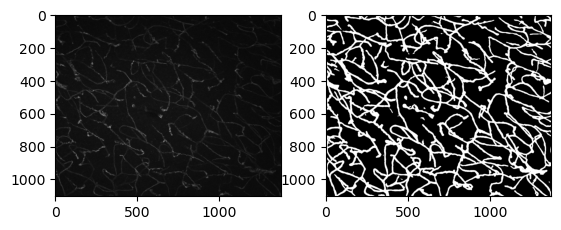

In [5]:
data_path = './data/original_images'
ORIG_MEAN, ORIG_STD = dataset_stats(data_path)
all_images = os.listdir(data_path)

for fname in valid_imgs:
    img = zscore(np.asarray(Image.open(f'./data/original_images/{fname}')), ORIG_MEAN, ORIG_STD)
    #img = np.asarray(Image.open(f'./data/original_images/{fname}'))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=0)
    img_tensor = torch.tensor(img, dtype=torch.float32)
    output = model(img_tensor)
    seg = torch.argmax(output, dim=1)[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img[0, 0], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(seg.detach().numpy(), cmap='gray')
    plt.show()
    break

In [6]:
# Augmented Vessels

import os
from PIL import Image
import numpy as np

# Carregando as imagens
def load_images_from_directory(directory_name, image_list = []):
    image_files = sorted(os.listdir(directory_name))

    images = []
    for file_name in image_files:
        if file_name.endswith('.tiff'):
            img_path = os.path.join(directory_name, file_name)
            img = zscore(np.asarray(Image.open(img_path)), ORIG_MEAN, ORIG_STD)
            #img = np.asarray(Image.open(f'./data/original_images/{fname}'))
            img = np.expand_dims(img, axis=0)
            img = np.expand_dims(img, axis=0)
            images.append(img)

    return images, image_list # Salvando as imagens na RAM porque a VRAM da gpu é liberada a cada cálculo
  
original_images,  image_list = load_images_from_directory("/home/fonta42/Desktop/interpretacao-redes-neurais/data/augmented_vessels")
np.array(original_images).shape

(11, 1, 1, 128, 128)

In [ ]:
image_list

In [7]:
import torch
import torch.nn.functional as F
import sys

def get_all_gradients(model, image, device="cuda", vectorize=False):

    model.to(device)
    model = model.train()
    model_wrapped = wrapper(model)
    img_tensor = torch.tensor(image, dtype=torch.float32).to('cuda')
    img_tensor.requires_grad = True


    #print(torch.max(img_tensor), torch.min(img_tensor))
    #print('img', img_tensor.shape)


    jacobian = torch.autograd.functional.jacobian(model_wrapped, img_tensor, vectorize=False)

    
    print(torch.max(jacobian))

    jacobian = jacobian.to('cpu')
    return jacobian

def wrapper(model):
    '''Wrap model to return probabilities and only the vessel channel.'''
    def new_model(img):
        #print('img ', img.shape)
        output = model(img)
        probs = F.softmax(output, dim=1)  #
        return probs[:, 1]
    return new_model

In [13]:
import time

# instanciando o modelo
model_layers = (1, 1, 1)
model_channels = (64, 64, 64)
model_augmented = torchtrainer.models.resunet.ResUNetV2((8,), (1,), (64,))
# carregando o state_dict
baseline_state_dict = torch.load('./unetv2_da/checkpoint_best.pth')['model']
#print(baseline_state_dict)
model_augmented.load_state_dict(baseline_state_dict)

for idx in range(11):
    
    start_time = time.time()  # Record the start time before extracting the gradient
    
    gradient = get_all_gradients(model_augmented, 
                                 original_images[idx])
    gradient = gradient.squeeze(0).squeeze(2).squeeze(2)
    print(gradient.shape)
    
    # Save the gradient
    torch.save(gradient, f'/home/fonta42/Desktop/interpretacao-redes-neurais/experiments/torchseg_gradients/augmented_vessels_trained_model/jacobian_gradient_{idx}.pt')
    #print(gradient)
    
    end_time = time.time()  # Record the end time after saving the gradient
    elapsed_time = end_time - start_time  # Calculate the elapsed time
    
    print(f"Gradient {idx} extraction and saving took {elapsed_time:.2f} seconds. Gradient shape {gradient.shape}")

tensor(0.5838, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 0 extraction and saving took 45.20 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tensor(0.8400, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 1 extraction and saving took 45.14 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tensor(0.8644, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 2 extraction and saving took 50.58 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tensor(1.0277, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 3 extraction and saving took 51.66 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tensor(1.1264, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 4 extraction and saving took 46.03 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tensor(0.8027, device='cuda:0')
torch.Size([128, 128, 128, 128])
Gradient 5 extraction and saving took 46.87 seconds. Gradient shape torch.Size([128, 128, 128, 128])
tens

KeyboardInterrupt: 